<div style="text-align: right" align="right"><i>Peter Norvig<br>December 1–25, 2021</i></div>

# Advent of Code 2021

I'm doing [Advent of Code](https://adventofcode.com/) (AoC) this year. I'm not competing for points\, just for fun.

To fully understand each puzzle you'll have to click on each day's link (e.g. [Day 1](https://adventofcode.com/2021/day/1)); I'll give only a partial description of the puzzles. 

Part of the idea of AoC is that you have to make some design choices to solve part 1 *before* you get to see the description of part 2. So there is a tension of wanting the solution to part 1 to provide general components that might be re-used in part 2, without falling victim to [YAGNI](https://en.wikipedia.org/wiki/You_aren%27t_gonna_need_it). In this notebook I won't refactor the code for part 1 based on what I see in part 2 (although I may edit the code for clarity, without changing the initial approach).

# Day 0: Preparations

First, imports that I have used in past AoC years:

In [1]:
from __future__  import annotations
from collections import Counter, defaultdict, namedtuple, deque
from itertools   import permutations, combinations, chain, count as count_from, product as cross_product
from typing      import *
from statistics  import mean, median

import matplotlib.pyplot as plt
import functools
import math
import re

Each day's work will consist of three tasks:
- **Input**: Parse the day's input file with the function `parse(day, parser, sep)`, which treats the input as a sequence of *entries*, separated by `sep` (default newline); applies `parser` to each entry; and returns the results as a tuple. (Note: `ints` and `atoms` are useful `parser` functions (as are `int` and `str`).)
- **Part 1**: Write code to compute the answer to Part 1, and submit the answer to the AoC site. Use the function `answer` to record the correct answer and serve as a regression test when I re-run the notebook.
- **Part 2**: Repeat coding and `answer` for Part 2.


In [2]:
def parse(day, parser=str, sep='\n') -> tuple:
    """Split the day's input file into entries separated by `sep`, and apply `parser` to each."""
    entries = open(f'AOC2021/input{day}.txt').read().rstrip().split(sep)
    return mapt(parser, entries)

def answer(puzzle_number, got, expected) -> bool:
    """Verify the answer we got was expected."""
    assert got == expected, f'For {puzzle_number}, expected {expected} but got {got}.'
    return True

def ints(text: str) -> Tuple[int]:
    """A tuple of all the integers in text, ignoring non-number characters."""
    return mapt(int, re.findall('-?[0-9]+', text))

Atom = Union[float, int, str]

def atoms(text: str, sep=None) -> Tuple[Atom]:
    """A tuple of all the atoms (numbers or strs) in text.
    By default, atoms are space-separated but you can change that with `sep`."""
    return tuple(map(atom, text.split(sep)))

def atom(text: str) -> Atom:
    """Parse text into a single float or int or str."""
    try:
        x = float(text)
        return round(x) if round(x) == x else x
    except ValueError:
        return text
    
def mapt(fn, *args):
    """map(fn, *args) and return the result as a tuple."""
    return tuple(map(fn, *args))

A few additional  utility functions that I have used in the past:

In [3]:
def quantify(iterable, pred=bool) -> int:
    "Count the number of items in iterable for which pred is true."
    return sum(1 for item in iterable if pred(item))

def multimap(items: Iterable[Tuple]) -> dict:
    "Given (key, val) pairs, return {key: [val, ....], ...}."
    result = defaultdict(list)
    for (key, val) in items:
        result[key].append(val)
    return result

def prod(numbers) -> float: # Will be math.prod in Python 3.8
    "The product of an iterable of numbers." 
    result = 1
    for n in numbers:
        result *= n
    return result

def total(counts: Counter) -> int: 
    """The sum of all the counts in a Counter."""
    return sum(counts.values())

Point = Tuple[int, int] # (x, y) points on a grid

class Grid(dict):
    """A 2D grid, indexed by (x, y) Points."""
    def __init__(self, mapping):
        """Initialize with a mapping of {(0, 0): val0, (0, 1): val1, ...}"""
        self.update(mapping)
        self.width = max(x for x, y in self)
        self.height = max(y for x, y in self)
        
    def neighbors(self, point):
        """The 4 orthogonal neighbors of a point, not going over edge."""
        x, y = point
        return [p for p in ((x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)) 
                if p in self]
    
    def neighbors8(self, point):
        """The 8 orthogonal and diagonal neighbors of a point, not going over edge."""
        x, y = point
        return [p for p in ((x + 1, y + 1), (x + 1, y - 1), (x - 1, y + 1), (x - 1, y - 1))
                if p in self] + self.neighbors(point)

def sign(x) -> int: return (0 if x == 0 else +1 if x > 0 else -1)
    
def dotproduct(A, B) -> float: return sum(a * b for a, b in zip(A, B))

def transpose(matrix) -> list: return list(zip(*matrix))

cat     = ''.join
flatten = chain.from_iterable
cache   = functools.lru_cache(None)

This year's AoC theme involves Santa's Elves on a submarine. [Gary J Grady](https://twitter.com/GaryJGrady/) has some nice drawings to set the scene:

<img src="https://pbs.twimg.com/media/FFiywKpWYAAm6B5?format=jpg&name=medium" width=300>

# [Day 1](https://adventofcode.com/2021/day/1): Sonar Sweep


- **Input**: Each entry in the input is an integer depth measurement, such as "`148`".


In [4]:
in1 = parse(1, int)

- **Part 1**: How many measurements are larger than the previous measurement?

In [5]:
def increases(nums: List[int]) -> int:
    """How many numbers are bigger than the previous one?"""
    return quantify(nums[i] > nums[i - 1] 
                    for i in range(1, len(nums)))

answer(1.1, increases(in1), 1400)

True

- **Part 2**: Consider sums of a three-measurement sliding window. How many sums are larger than the previous sum?

In [6]:
def window_increases(nums: List[int], w=3) -> int:
    """How many sliding windows of w numbers have a sum bigger than the previous window?"""
    return quantify(sum(nums[i:i+w]) > sum(nums[i-1:i-1+w])
                    for i in range(1, len(nums) + 1 - w))

answer(1.2, window_increases(in1), 1429)

True

# [Day 2](https://adventofcode.com/2021/day/2): Dive! 

- **Input**: Each entry in the input is a command, like "`forward 1`", "`down 2`", or "`up 3`".

I'll parse a command into a tuple like `('forward', 1)`.

In [7]:
in2 = parse(2, atoms)

- **Part 1**: Calculate the horizontal position and depth you would have after following the planned course. What do you get if you multiply your final horizontal position by your final depth?

In [8]:
def drive(commands) -> int:
    """What is the product of position and depth after following commands?"""
    pos = depth = 0
    for (op, n) in commands:
        if op == 'forward': pos += n
        if op == 'down':    depth += n
        if op == 'up':      depth -= n
    return pos * depth

answer(2.1, drive(in2), 1670340)

True

- **Part 2**: Using the new interpretation of the commands, calculate the horizontal position and depth you would have after following the planned course. What do you get if you multiply your final horizontal position by your final depth? 

The new interpretation is that the "down" and "up" commands no longer change depth, rather they change *aim*, and going forward *n* units both increments position by *n* and depth by *aim* × *n*.

In [9]:
def drive2(commands) -> int:
    """What is the product of position and depth after following commands?
    This time we have to keep track of `aim` as well."""
    pos = depth = aim = 0
    for (op, n) in commands:
        if op == 'forward': pos += n; depth += aim * n
        if op == 'down':    aim += n
        if op == 'up':      aim -= n
    return pos * depth

answer(2.2, drive2(in2), 1954293920)

True

# [Day 3](https://adventofcode.com/2021/day/3): Binary Diagnostic

- **Input**: Each entry in the input is a bit string, such as "`101000111100`".

I'll parse them as strings; I won't convert them into ints.

In [10]:
in3 = parse(3, str)

- **Part 1**: What is the power consumption of the submarine (product of gamma and epsilon rates)?

In [11]:
def common(strs, i) -> str: 
    """The bit that is most common in position i."""
    bits = [s[i] for s in strs]
    return '1' if bits.count('1') >= bits.count('0') else '0'

def uncommon(strs, i) -> str: 
    """The bit that is least common in position i."""
    return '1' if common(strs, i) == '0' else '0'

def epsilon(strs) -> str:
    """The bit string formed from most common bit at each position."""
    return cat(common(strs, i) for i in range(len(strs[0])))

def gamma(strs) -> str:
    """The bit string formed from most uncommon bit at each position."""
    return cat(uncommon(strs, i) for i in range(len(strs[0])))

def power(strs) -> int: 
    """Product of epsilon and gamma rates."""
    return int(epsilon(strs), 2) * int(gamma(strs), 2)
    
answer(3.1, power(in3), 2261546)

True

- **Part 2**: What is the life support rating of the submarine (product of oxygen and CO2)?

In [12]:
def select_str(strs, common_fn, i=0) -> str:
    """Select a str from strs according to common_fn:
    Going left-to-right, repeatedly select just the strs that have the right i-th bit."""
    if len(strs) == 1:
        return strs[0]
    else:
        bit = common_fn(strs, i)
        selected = [s for s in strs if s[i] == bit]
        return select_str(selected, common_fn, i + 1)

def life_support(strs) -> int: 
    """The product of oxygen (most common select) and CO2 (least common select) rates."""
    return int(select_str(strs, common), 2) * int(select_str(strs, uncommon), 2)
    
answer(3.2, life_support(in3), 6775520)

True

# [Day 4](https://adventofcode.com/2021/day/4): Giant Squid

- **Input**: The first entry of the input is a permutation of the integers 0-99. Subsequent entries are bingo boards: 5 lines of 5 ints each. Entries are separated by *two* newlines. (Bingo games will be played against a giant squid.)

I'll represent a board as a tuple of 25 ints; that makes `parse` easy: the permutation of integers and the bingo boards can both be parsed by `ints`. 

In [13]:
order, *boards = in4 = parse(4, ints, sep='\n\n')

- **Part 1**: What will your final score be if you choose the first bingo board to win?

I'm worried about an ambiguity: what if two boards win at the same time? I'll have to assume Eric arranged it so that can't happen. I'll define `bingo_winners` to return a list of boards that win when a number has just been called, and I'll arbitrarily choose the first of them.

In [14]:
Board = Tuple[int]
Line = List[int]
B = 5
def sq(x, y) -> int: "The index number of the square at (x, y)"; return x + B * y

def lines(square) -> Tuple[Line, Line]:
    """The two lines through square number `square`."""
    return ([sq(x, square // B) for x in range(B)], 
            [sq(square % B, y)  for y in range(B)])

def bingo_winners(boards, drawn, just_called) -> List[Board]:
    """Boards that win due to the number just called."""
    def filled(board, line) -> bool: return all(board[n] in drawn for n in line)
    return [board for board in boards
            if just_called in board
            and any(filled(board, line) for line in lines(board.index(just_called)))]

def bingo_score(board, drawn, just_called) -> int:
    """Sum of unmarked numbers multiplied by the number just called."""
    unmarked = sum(n for n in board if n not in drawn)
    return unmarked * just_called

def bingo(boards, order) -> int: 
    """What is the final score of the first winning board?"""
    drawn = set()
    for num in order:
        drawn.add(num)
        winners = bingo_winners(boards, drawn, num)
        if winners:
            return bingo_score(winners[0], drawn, num)

answer(4.1, bingo(boards, order), 39902)

True

- **Part 2**: Figure out which board will win last. Once it wins, what would its final score be?

In [15]:
def bingo_last(boards, order) -> int: 
    """What is the final score of the last winning board?"""
    boards = set(boards)
    drawn = set()
    for num in order:
        drawn.add(num)
        winners = bingo_winners(boards, drawn, num)
        boards -= set(winners)
        if not boards:
            return bingo_score(winners[-1], drawn, num)
                
answer(4.2, bingo_last(boards, order), 26936)

True

<img src="https://pbs.twimg.com/media/FFykNslXMAwe_xA?format=jpg&name=medium" width=300 title="Drawing by Gary Grady @GaryJGrady">

# [Day 5](https://adventofcode.com/2021/day/5): Hydrothermal Venture

- **Input**: Each entry in the input is a "line" denoted by start and end x,y points, e.g. "`0,9 -> 5,9`". I'll represent a line as a 4-tuple of integers, e.g. `(0, 9, 5, 9)`.

In [16]:
in5 = parse(5, ints)

- **Part 1**: Consider only horizontal and vertical lines. At how many points do at least two lines overlap?

In [17]:
def points(line) -> bool:
    """All the (integer) points on a line."""
    x1, y1, x2, y2 = line
    if x1 == x2:
        return [(x1, y) for y in cover(y1, y2)]
    elif y1 == y2:
        return [(x, y1) for x in cover(x1, x2)]
    else: # non-orthogonal lines not allowed
        return []
    
def cover(x1, x2) -> range:
    """All the ints from x1 to x2, inclusive, with x1, x2 in either order."""
    return range(min(x1, x2), max(x1, x2) + 1)

def overlaps(lines) -> int:
    """How many points overlap 2 or more lines?"""
    counts = Counter(flatten(map(points, lines)))
    return quantify(counts[p] >= 2 for p in counts)

answer(5.1, overlaps(in5), 7436)

True

- **Part 2**: Consider all of the lines (including diagonals, which are all at ±45°). At how many points do at least two lines overlap?

For part 2 I'll redefine `points` and `overlaps` in a way that doesn't break part 1:

In [18]:
def points(line, diagonal=False) -> bool:
    """All the (integer) points on a line; optionally allow diagonal lines."""
    x1, y1, x2, y2 = line
    if diagonal or x1 == x2 or y1 == y2:
        dx, dy = sign(x2 - x1), sign(y2 - y1)
        length = max(abs(x2 - x1), abs(y2 - y1))
        return [(x1 + k * dx, y1 + k * dy) for k in range(length + 1)]
    else: # non-orthogonal lines not allowed when diagonal is False
        return []
    
def overlaps(lines, diagonal=False) -> int:
    """How many points overlap 2 or more lines?"""
    counts = Counter(flatten(points(line, diagonal) for line in lines))
    return quantify(counts[p] >= 2 for p in counts)

assert points((1, 1, 1, 3), False) == [(1, 1), (1, 2), (1, 3)]
assert points((1, 1, 3, 3), False) == []
assert points((1, 1, 3, 3), True) == [(1, 1), (2, 2), (3, 3)]
assert points((9, 7, 7, 9), True) == [(9, 7), (8, 8), (7, 9)]

answer(5.1, overlaps(in5, False), 7436)
answer(5.2, overlaps(in5, True), 21104)

True

# [Day 6](https://adventofcode.com/2021/day/6): Lanternfish

- **Input**: The input is a single line of comma-separated integers, each one the age of a lanternfish. Over time, the lanternfish age and reproduce in a specified way.

In [19]:
in6 = parse(6, int, sep=',')

- **Part 1**: Find a way to simulate lanternfish. How many lanternfish would there be after 80 days?

Although the puzzle description treats each fish individually, I won't take the bait (pun intended). Instead, I'll use a `Counter` of fish, and treat all the fish of each age group together. I have a hunch that part 2 will involve a ton-o'-fish.

In [20]:
Fish = Counter # Represent a school of fish as a Counter of their timer-ages

def simulate(fish, days=1) -> Fish:
    """Simulate the aging and birth of fish over `days`."""
    for day in range(days):
        fish = Fish({t - 1: fish[t] for t in fish})
        if -1 in fish: # births
            fish[6] += fish[-1]
            fish[8] = fish[-1]
            del fish[-1]
    return fish
        
assert simulate(Fish((3, 4, 3, 1, 2))) == Fish((2, 3, 2, 0, 1))
assert simulate(Fish((2, 3, 2, 0, 1))) == Fish((1, 2, 1, 6, 0, 8))

answer(6.1, total(simulate(Fish(in6), 80)), 350917)

True

- **Part 2**: How many lanternfish would there be after 256 days?

My hunch was right, so part 2 is simple:

In [21]:
answer(6.2, total(simulate(Fish(in6), 256)), 1_592_918_715_629)

True

<img src="https://pbs.twimg.com/media/FF9GGGJXEAEQ0MD?format=jpg&name=medium" width=300 title="Drawing by Gary Grady @GaryJGrady">

# [Day 7](https://adventofcode.com/2021/day/7): The Treachery of Whales

- **Input**: The input is a single line of comma-separated integers, each one the horizontal position of a crab (in its own submarine).

In [22]:
in7 = parse(7, int, sep=',')

- **Part 1**: Determine the horizontal position that the crabs can align to using the least fuel possible.  How much fuel must they spend to align to that position? (Each unit of travel costs one unit of fuel.)

In [23]:
def fuel_cost(positions) -> int:
    """How much fuel does it cost to get everyone to the best alignment point?"""
    # I happen to know that the best alignment point is the median
    align = median(positions)
    return sum(abs(p - align) for p in positions)

answer(7.1, fuel_cost(in7), 352707)

True

- **Part 2**: Determine the horizontal position that the crabs can align to using the least fuel possible so they can make you an escape route! How much fuel must they spend to align to that position? (Now for each crab the first unit of travel costs 1, the second 2, the third 3, and so on.) 

In [24]:
def fuel_cost2(positions) -> int:
    """How much fuel does it cost to get everyone to the best alignment point, 
    with nonlinear fuel costs?"""
    # I don't know the best alignment point, so I'll try all of them
    return min(sum(burn_rate2(p, align) for p in positions)
               for align in range(min(positions), max(positions) + 1))

def burn_rate2(p, align) -> int:
    """The first step costs 1, the second 2, etc. (i.e. triangular numbers)."""
    steps = abs(p - align)
    return steps * (steps + 1) // 2

answer(7.2, fuel_cost2(in7), 95519693)

True

**Note**: Now that I got the right answer and have some time to think about it, if the travel cost were exactly quadratic, we would be minimizing the sum of square distances, and Legendre and Gauss knew that the **mean**, not the **median**, is the alignment point that does that. What's the mean of the positions?

In [25]:
positions = in7
mean(positions)

490.543

That's not an integer, but I'll try it, along with the integers above and below it:

In [26]:
{align: sum(burn_rate2(p, align) for p in positions)
 for align in [490, 491, mean(positions)]}

{490: 95519693, 491: 95519725, 490.543: 95519083.0}

We see that rounding down gives the right answer, rounding up does a bit worse, and using the exact mean  gives a total fuel cost that is *better* than the correct answer (but is apparently not a legal alignment point).

# [Day 8](https://adventofcode.com/2021/day/8): Seven Segment Search

- **Input**: Each entry in the input is 10 patterns followed by 4 output values, in the form:

      be cfbegad cbdgef fgaecd cgeb fdcge agebfd fecdb fabcd edb | edb cefdb eb gcbe
      
Each pattern and output value represents a digit, with each letter representing one of the segments in a [7-segment display](https://en.wikipedia.org/wiki/Seven-segment_display). The mapping of letters to segments is unknown, but is consistent within each entry.

In [27]:
def segment_parser(line) -> tuple: return mapt(atoms, line.split('|'))

in8 = parse(8, segment_parser)

In [28]:
assert (segment_parser('be cfbegad cbdgef fgaecd cgeb fdcge agebfd fecdb fabcd edb | edb cefdb eb gcbe')
        == (('be', 'cfbegad', 'cbdgef', 'fgaecd', 'cgeb', 'fdcge', 'agebfd', 'fecdb', 'fabcd', 'edb'), 
            ('edb', 'cefdb', 'eb', 'gcbe')))

<img src="https://pbs.twimg.com/media/FGHtjKiWYAQGrBX?format=jpg&name=medium" width=300 title="@GaryJGrady">

- **Part 1**: In the output values, how many times do digits 1, 4, 7, or 8 appear?

That's the same as asking *how many values have 2, 4, 3, or 7 segments?*

In [29]:
def count1478(entries) -> int:
    """How many of the rhs digits in all the entries are a 1, 4, 7, or 8?"""
    return sum(len(value) in (2, 4, 3, 7) for (lhs, rhs) in entries for value in rhs)

answer(8.1, count1478(in8), 493)

True

- **Part 2**: For each entry, determine all of the wire/segment connections and decode the four-digit output values. What do you get if you add up all of the output values?

Part 2 is *tricky*. The value `'cefdb'` could be either a 2, 3, or 5. To figure out which one it is I could do some fancy constraint satisfaction, but that sounds hard. Or I could exhaustively try all permutations of the seven segments. That sounds easy!  Here's my plan:
- Make a list of the 7! = 5,040 possible string translators that permute `'abcdefg'`.
- Decode an entry by trying all translators and keeping the one that maps all of the ten lhs patterns to a valid digit. `decode` then applies the translator to the rhs and forms it into an `int`.
  - Note that `get_digit` must sort the translated letters to get a key that can be looked up in `segment_map`.
- Finally, sum up the decoding of each entry.

In [30]:
segments7    = 'abcdefg'
segment_map  = {'abcefg': '0', 'cf':     '1', 'acdeg': '2', 'acdfg':   '3', 'bcdf':   '4',
                'abdfg':  '5', 'abdefg': '6', 'acf':   '7', 'abcdefg': '8', 'abcdfg': '9'}

translators = [str.maketrans(segments7, cat(p)) for p in permutations(segments7)]

def get_digit(pattern, translator) -> Optional[Char]:
    """Translate the pattern, and return a digit '0' to '9' if valid."""
    return segment_map.get(cat(sorted(pattern.translate(translator))))

def decode(entry) -> int:
    """Decode an entry's rhs into a 4-digit integer."""
    lhs, rhs = entry
    for t in translators:
        if all(get_digit(pattern, t) for pattern in lhs):
            return int(cat(get_digit(pattern, t) for pattern in rhs))

answer(8.2, sum(map(decode, in8)), 1010460)

True

# [Day 9](https://adventofcode.com/2021/day/9): Smoke Basin

- **Input:** The input is a *heightmap*: a 2D array of characters '0'–'9' representing the heights on the ocean floor. 

I'll use `parse` to get a tuple of strings such as `"2199943210"`, and then use `Grid` to define `g9` as a grid of `{location: height}` where `location` is an `(x, y)` Point and `height` is an int from 0 to 9.

In [31]:
in9 = parse(9)

g9 = Grid({(x, y): int(height) 
           for x, row in enumerate(in9) 
           for y, height in enumerate(row)})

- **Part 1**: Find all of the low points on your heightmap. What is the sum of the risk levels of all low points on your heightmap?

A low point is a point where all the neighbors are higher. The risk level is 1 more than the height of the low point.

In [32]:
def low_points(grid) -> List[Point]:
    """All low points on map M."""
    return [p for p in grid 
            if all(grid[p] < grid[nbr] for nbr in grid.neighbors(p))]

def total_risk(grid) -> int:
    """Sum of height + 1 for all low points on map M."""
    return sum(grid[p] + 1 for p in low_points(grid))

answer(9.1, total_risk(g9), 607)

True

- **Part 2**: What do you get if you multiply together the sizes of the three largest basins?
    
I thought there was an ambiguity in the definition of *basin*: what happens if there is a high point that is not of height 9? The puzzle description says *Locations of height 9 do not count as being in any basin, and all other locations will always be part of exactly one basin.* I decided this must mean that basins are surrounded by either edges or height 9 locations.

Given that definition of *basin,* I can associate each location with its low point using a [flood fill](https://en.wikipedia.org/wiki/Flood_fill) from each low point, and then get the sizes of the three largest (most common) basins.

In [33]:
def flood_fill(grid) -> Dict[Point, Point]:
    """Compute `basins` as a map of {point: low_point} for each point in grid."""
    basins = {} # A dict mapping each non-9 location to its low point.
    def flood(p, low):
        """Spread from p in all directions until hitting a 9 or an edge;
        mark each point p as being part of the basin starting at `low` point."""
        if grid[p] < 9 and p not in basins:
            basins[p] = low
            for p2 in grid.neighbors(p):
                flood(p2, low)
    for p in low_points(grid):
        flood(p, p)
    return basins

def flood_size_products(grid, k=3) -> int:
    """The product of the sizes of the `k` largest basins."""
    basins = flood_fill(grid)
    return prod(c for _, c in Counter(basins.values()).most_common(k))

answer(9.2, flood_size_products(g9), 900864)

True

That's the correct answer; I'm done. But I do want to check that the set of low points is the same as the set of basins I identified:

In [34]:
assert set(low_points(g9)) == set(flood_fill(g9).values())

len(low_points(g9))

249

I would like to visualize the basins. I'll use a scatter plot with a color map that displays the 9 heights in yellow and the 0 heights in deep purple, with a gradient in between:

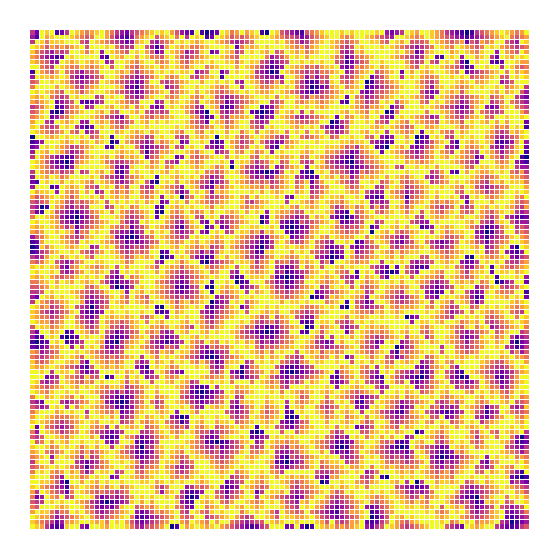

In [35]:
def show(g9, low=None):
    plt.figure(figsize=(10, 10))
    C = [g9[p] for p in g9]
    plt.scatter(*transpose(g9), marker='s', s=10, c=C, cmap=plt.get_cmap('plasma'))
    if low: plt.plot(*transpose(low_points(g9)), low, markersize=4)
    plt.axis('square'); plt.axis('off')
    
show(g9)

We can optionally display the low points. Here I'll display them as black diamonds:

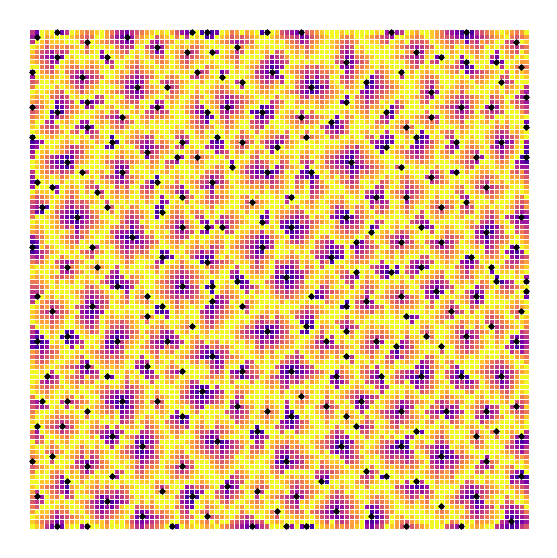

In [36]:
show(g9, 'kD')

Apropos to "smoke in the water," and to the color scheme of my plot, Gary Grady's drawing for the day references  Deep Purple.

<img src="https://pbs.twimg.com/media/FGL7YhbX0BAHDDt?format=jpg&name=medium" title="@GaryJGrady" width=300>

# [Day 10](https://adventofcode.com/2021/day/10): Syntax Scoring

- **Input**: Each entry in the input is a supposedly balanced string, but it may be:
  - Corrupted:  "`{{([]<>)]}`" should end in `}}`, not `]}`
  - Incomplete: "`{{([]<>)`" needs to have `}}` added to be complete.

I'll parse the entries as strs:

In [37]:
in10 = parse(10)

- **Part 1**: Find the first illegal character in each corrupted line of the navigation subsystem. What is the total syntax error score for those errors?

When the instructions for Part 1 say "you can ignore these [incomplete] lines for now," I'm pretty sure we will need to deal with incomplete lines on Part 2. So I'll define `analyze_syntax` to return a tuple of two values: an error score and the expected characters for an incomplete line.

In [38]:
error_scores = {')': 3, ']': 57, '}': 1197, '>': 25137}
open_close   = {'(': ')', '[': ']', '{': '}', '<': '>'}

def analyze_syntax(line) -> Tuple[int, str]:
    """A tuple of (error_score, expected_chars) for this line."""
    stack = [''] # A stack of closing characters we are looking for.
    for c in line:
        if c == stack[-1]:
            stack.pop()
        elif c in open_close:
            stack.append(open_close[c])
        else: # erroneous character
            return error_scores[c], cat(reversed(stack))
    return 0, cat(reversed(stack))
        
answer(10.1, sum(analyze_syntax(line)[0] for line in in10), 367059)

True

- **Part 2**: Find the completion string for each incomplete line, score the completion strings, and sort the scores. What is the middle score?

To score the completion string, we essentially treat it as a base-5 number, as shown in `completion_score`.

In [41]:
def completion_score(completion:str) -> int:
    """The completion score for the completion string."""
    score = completion.translate(str.maketrans(')]}>', '1234'))
    return int(score, base=5)

def median_completion_score(lines) -> int:
    """The median completion score out of all the uncorrupted lines."""
    return median(completion_score(completion) 
                  for e, completion in map(analyze_syntax, lines) 
                  if e == 0)

answer(10.2, median_completion_score(in10), 1952146692)

True

# [Day 11](https://adventofcode.com/2021/day/11): ???